# 폰트 다운

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (4,297 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

# 모듈, 폰트 설정

In [1]:
import os, os.path, json, folium, requests, re, time, math
from folium import plugins
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import MarkerCluster
import requests; from urllib.parse import urlparse
import pandas as pd
import plotly.express as px
import numpy as np
from tqdm import tqdm

if os.name == 'posix':  
    plt.rc("font", family="AppleGothic")    #mac일경우
else: 
    plt.rc("font", family="Malgun Gothic")    #그외에 다른거일경우
    
plt.rc('font', family='NanumBarunGothic') 

# colab일 경우 drive-mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd '/content/drive/MyDrive/태양광_입지분석/data'

/content/drive/.shortcut-targets-by-id/1yl3R1FqwCLSKTrTwfhZy_IirmexoxkSX/태양광_입지분석/data


# 2010년~2020년까지 에너지 수급 현황 시각화

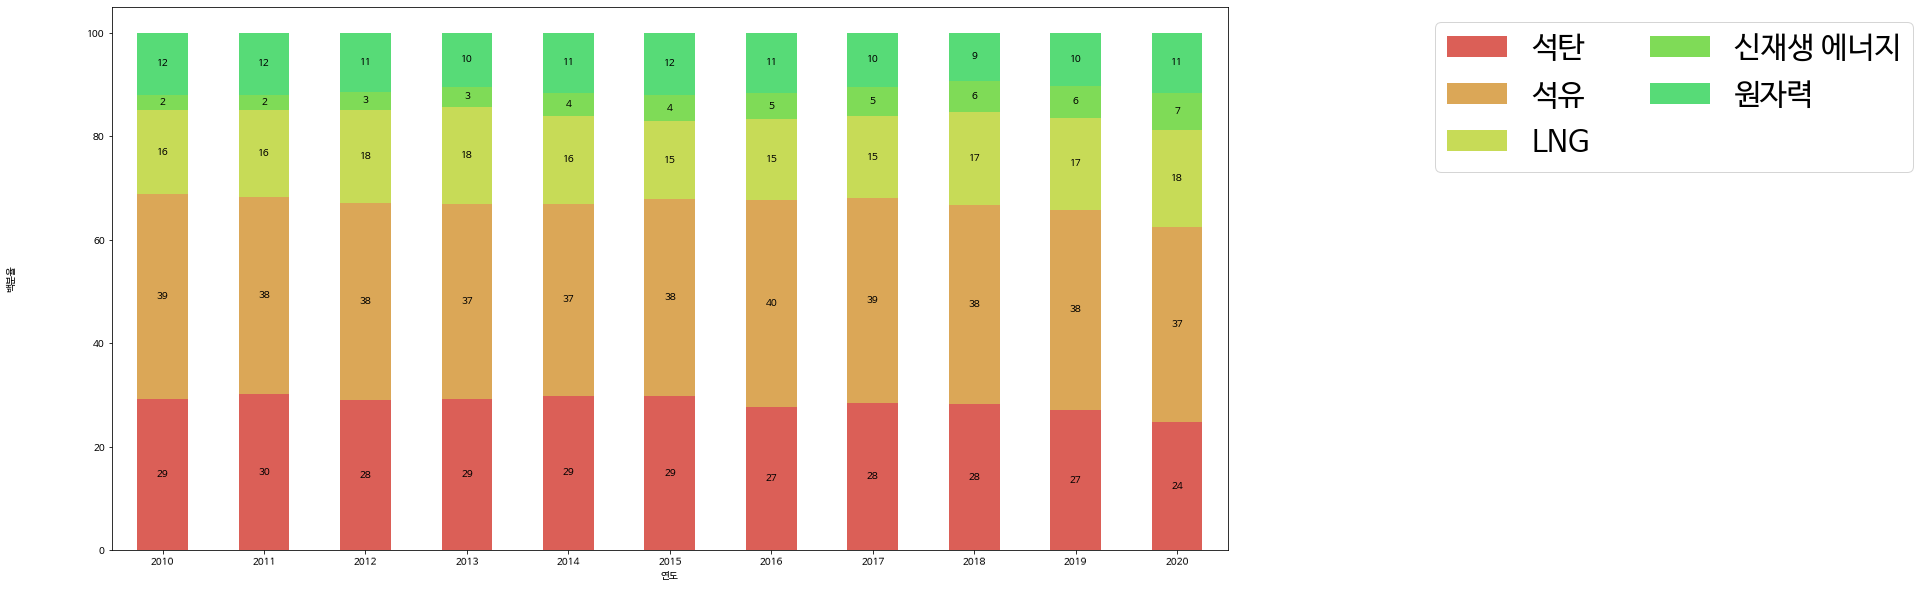

In [4]:
energy_df = pd.read_csv('./10년 에너지 현황.csv',encoding='cp949')

a,b,c,d,e,f = list(), list(), list(), list(), list(), list()
def D(val):
    return int(re.sub(',','',val))

for i in range(len(energy_df)):      # ,(콤마)지우기
    num = D(energy_df.loc[i,'합계'])
    num1 = D(energy_df.loc[i,'수력'])
    num2 = D(energy_df.loc[i,'신재생 및 기타'])
    num3 = D(energy_df.loc[i,'석탄'])
    num4 = D(energy_df.loc[i,'석유'])
    num5 = D(energy_df.loc[i,'LNG'])
    num6 = D(energy_df.loc[i,'원자력'])
    a.append(num), b.append(num1 + num2), d.append(num3) , e.append(num4), f.append(num5), c.append(num6)
    
energy_df['합계'], energy_df['신재생 에너지'], energy_df['석탄'], energy_df['석유'], energy_df['LNG'], energy_df['원자력'] = a,b,d,e,f,c

energy_df = energy_df.loc[:,['합계','연도','석탄','석유','LNG','신재생 에너지','원자력']]
x = energy_df.loc[:,'연도']
name = energy_df.columns
data = {}

for i in range(2,7):
    per = list()
    for j in range(11):
        per.append(energy_df.iloc[j,i] / energy_df.iloc[j,0] * 100)      # 백분율로 변환
    data[name[i]] = per
    
df = pd.DataFrame(data,index=x)
colors = sns.color_palette('hls',len(x)) ## 색상 지정

ax = df.plot(kind="bar",stacked=True,figsize=(20,10),color = colors)      # stacked


for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    label_text = height
    label_x = x + width / 2
    label_y = y + height / 2

    if label_text == 0: continue

    ax.text(label_x, label_y, int(label_text), ha='center',    
            va='center')
    
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.xticks(rotation = 1)        # x축 정방향으로 바꾸기
plt.ylabel('백분율',labelpad=70)
plt.legend(loc='upper center', ncol=2,fontsize=30,bbox_to_anchor=(1.4, 1))

plt.show()

# 전체 유휴부지 분석

[사용할 데이터의 목록]
- 폐학교 (o)
- 폐철도 (o)
- 서울시 자투리땅 (o)

In [25]:
leftover = pd.read_csv('./유휴부지목록 (22.03월) (2).csv') # 자투리 땅
school = pd.read_csv('./폐교정보.csv',encoding='cp949',on_bad_lines='skip') # 학교
railRoad = pd.read_csv("./Nrel_alldata.csv",encoding='cp949') # 폐철도

## 폐학교

In [26]:
school.drop(columns={'Unnamed: 16'},inplace=True)

# 결측치가 있는 행은 삭제한다.
school.dropna(inplace=True)
school = school.loc[:,['지역구분',' 활용현황',' 대지면적',' 대장가격']]    # 필요한 값만 가져온다
school = school.reset_index()
school.drop(columns={'index'},inplace=True)

# 대지면적, 대장가격에 숫자가 아닌 공백이나 한글이 있을경우 0으로 바꿔준다.
for i in range(len(school)):
    try:
      float(school.loc[i,' 대지면적'])
    except:
       school.loc[i,' 대지면적'] = 0
    
    try:
       float(school.loc[i,' 대장가격'])
    except:
      school.loc[i,' 대장가격'] = 0

In [27]:
school[' 대지면적'] = school[' 대지면적'].astype('float')
school[' 대장가격'] = school[' 대장가격'].astype('float')

In [28]:
# 미활용 폐교
NotUse_school_area = int(school[school[' 활용현황'] == ' 미활용'][' 대지면적'].sum()) 
NotUse_school_cost = int(school[school[' 활용현황'] == ' 미활용'][' 대장가격'].sum())

# 활용 폐교
Use_school_area = int(school[school[' 활용현황'] != ' 미활용'][' 대지면적'].sum()) 
Use_school_cost = int(school[school[' 활용현황'] != ' 미활용'][' 대장가격'].sum()) 

print('미활용 폐교 대지면적: ', NotUse_school_area, '미활용 폐교 대장가격: ',NotUse_school_cost)
print('활용 폐교 대지면적: ',Use_school_area, '활용 폐교 대장가격',Use_school_cost)

미활용 폐교 대지면적:  33867249 미활용 폐교 대장가격:  324011285
활용 폐교 대지면적:  18430101 활용 폐교 대장가격 1443062238


### 지역별 미활용, 활용 폐교 수의 면적 합 시각화

In [29]:
school_df = school.copy()
NotUse=pd.DataFrame(columns=['지역구분','미활용_폐교면적'])
Use=pd.DataFrame(columns=['지역구분','활용중_폐교면적'])


In [30]:
# 지역별로 미활용, 활용중인 폐교 면적의 합 구하기
# 활용/미활용으로 분리
for i in tqdm(range(len(school_df))):
    if school_df.loc[i,' 활용현황']==' 미활용':
        # 마지막줄 뒤에 미활용 데이터 추가
        NotUse.loc[len(Use)+1]=[school_df.loc[i,'지역구분'],float(school_df.loc[i,' 대지면적'])]
    else:
        Use.loc[len(Use)+1]=[school_df.loc[i,'지역구분'],float(school_df.loc[i,' 대지면적'])]

100%|██████████| 1236/1236 [00:02<00:00, 447.41it/s]


In [31]:
Use_Region=Use.groupby('지역구분').sum()  
Use_Region

,활용중_폐교면적
지역구분,
강원,3070569.70
경기,1280871.20
경남,1367027.50
경북,2600482.63
광주,61970.00
대구,178920.60
대전,12502.00
부산,218422.80
울산,138961.40


In [32]:
NotUse_Region=NotUse.groupby('지역구분').sum()  
NotUse_Region

,미활용_폐교면적
지역구분,
강원,426764.0
경기,184798.0
경남,457611.7
경북,476224.0
대전,11937.0
부산,65458.0
서울,11076.5
울산,24791.0
인천,26326.0


In [33]:
new_row1 = pd.DataFrame([0],index=['광주'],columns=NotUse_Region.columns)
NotUse_Region=pd.concat([NotUse_Region.iloc[:4,:],new_row1,NotUse_Region.iloc[4:,:]])

new_row2 = pd.DataFrame([0],index=['대구'],columns=NotUse_Region.columns)
NotUse_Region=pd.concat([NotUse_Region.iloc[:5,:],new_row2,NotUse_Region.iloc[5:,:]])

In [34]:
new_row = pd.DataFrame([0],index=['서울'],columns=Use_Region.columns)
Use_Region=pd.concat([Use_Region.iloc[:8,:],new_row,Use_Region.iloc[8:,:]])

In [35]:
NotUse_Region=NotUse_Region.sort_values(by='미활용_폐교면적',ascending=False)

In [36]:
new_index=NotUse_Region.index
new_index

Index(['전남', '경북', '경남', '강원', '충북', '경기', '충남', '부산', '제주', '인천', '울산', '대전',
       '서울', '전북', '광주', '대구'],
      dtype='object')

In [37]:
Use_Region=Use_Region.reindex(new_index)
Use_Region

,활용중_폐교면적
전남,1798363.47
경북,2600482.63
경남,1367027.50
강원,3070569.70
충북,6292242.60
경기,1280871.20
충남,442880.00
부산,218422.80
제주,126515.00
인천,104198.00


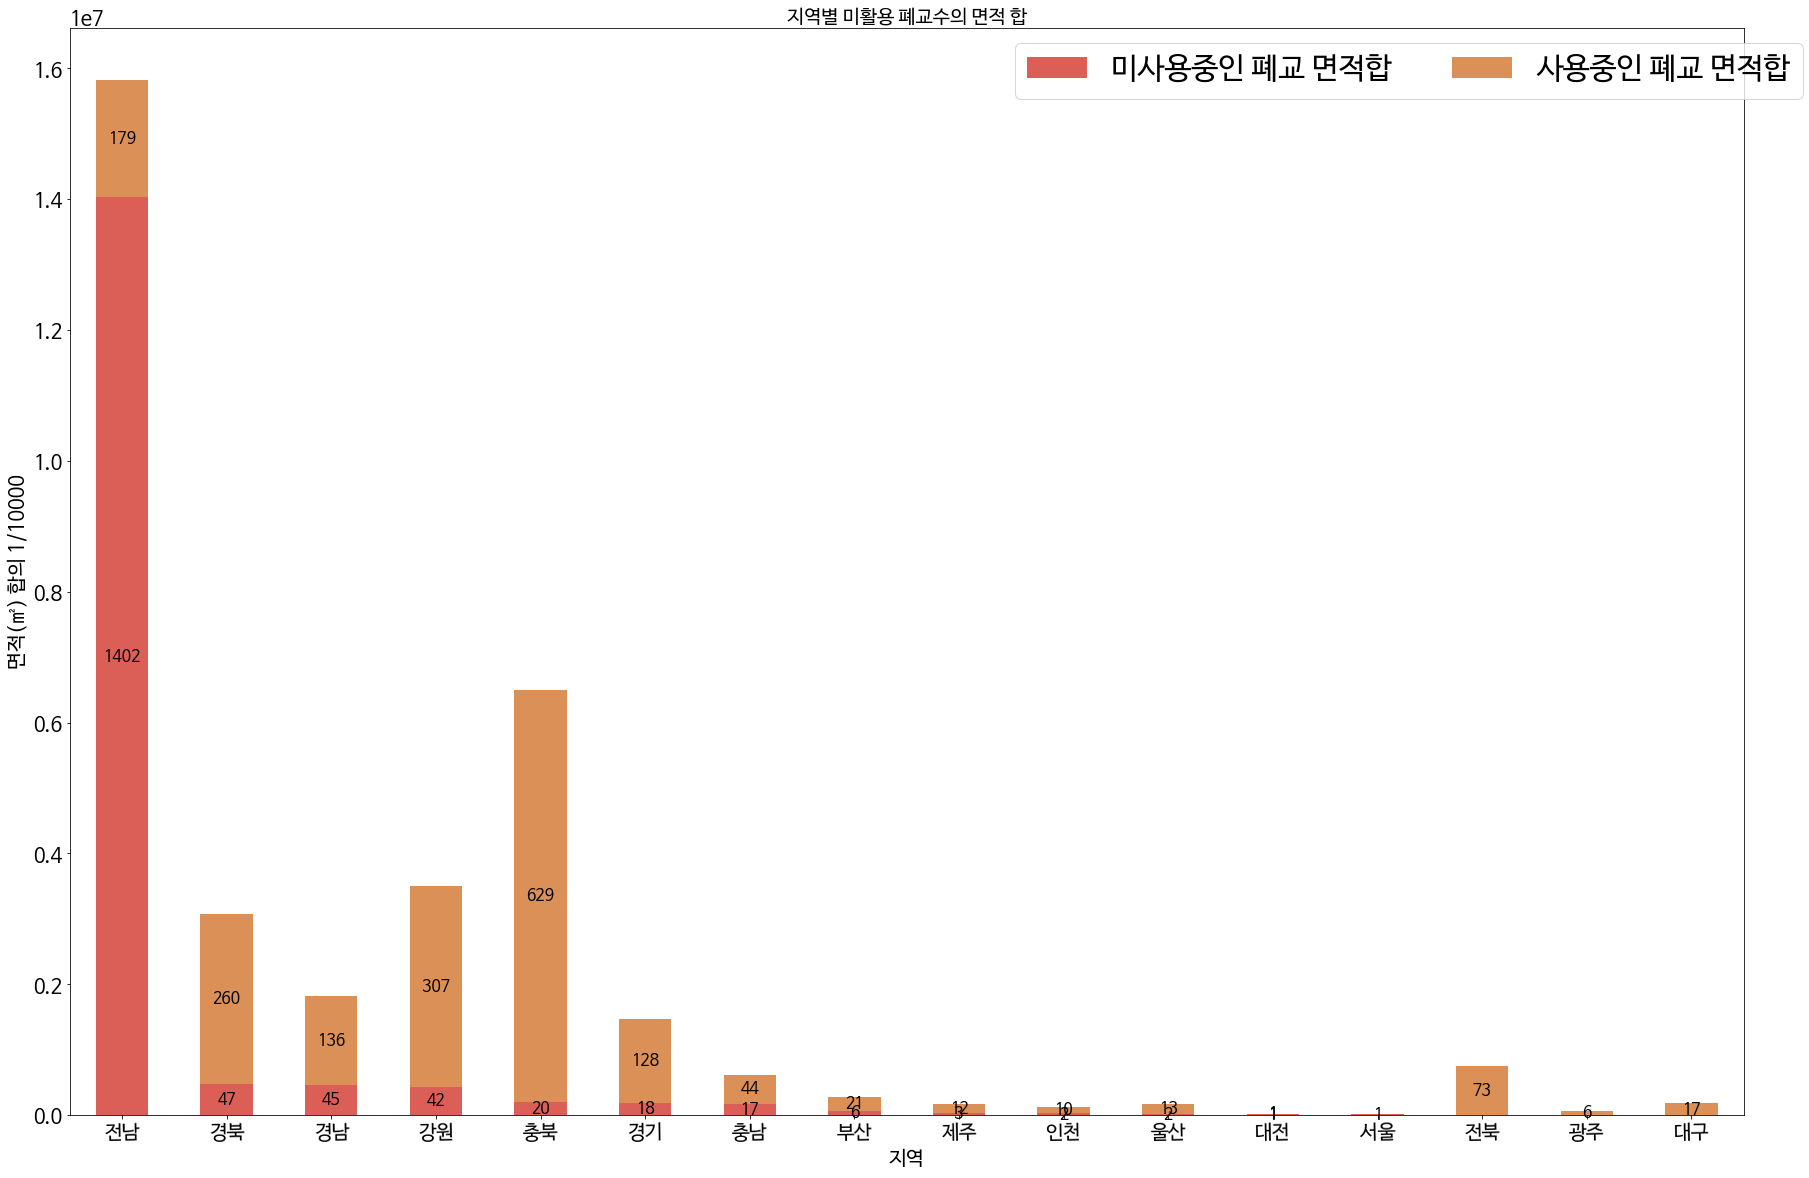

In [38]:
#-------------------------------------누적 막대그래프 그리기-------------------------------------
x = list(NotUse_Region.index)          # x축은 지역명

data = {                               # 누적 그래프 내용은 각각 미활용, 활용 폐교 수 이다.
    "미사용중인 폐교 면적합":list(NotUse_Region.loc[:,'미활용_폐교면적']),
    "사용중인 폐교 면적합":list(Use_Region.loc[:,'활용중_폐교면적'])
}

df = pd.DataFrame(data,index=x)
colors = sns.color_palette('hls',len(x)) ## 색상 지정

ax = df.plot(kind="bar",stacked=True,figsize=(30,20),color = colors)      # stacked
for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    label_text = int(height / 10000)
    label_x = x + width / 2
    label_y = y + height / 2

    if label_text <= 0: continue
    ax.text(label_x, label_y, label_text, ha='center',    
          va='center')
    
plt.title('지역별 미활용 폐교수의 면적 합')
plt.xlabel('지역')
plt.ylabel('면적(㎡) 합의 1/10000')
plt.rc('font', family='NanumBarunGothic') 
plt.rc('font', size=25)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.xticks(rotation = 1)        # x축 정방향으로 바꾸기
plt.legend(loc='upper center', ncol=2,fontsize=30,bbox_to_anchor=(0.8, 1))
plt.show()


## 폐철도

In [39]:
railRoad_AllArea = railRoad[['면적','활용여부']]
NotUse_rail_area = railRoad_AllArea[railRoad_AllArea['활용여부'] == '미사용']['면적'].sum()
Use_rail_area = railRoad_AllArea[railRoad_AllArea['활용여부'] != '미사용']['면적'].sum()
NotUse_rail_area, Use_rail_area

(6722707, 10801963)

### 미활용, 활용 폐철도의 지역별 면적 시각화

In [40]:
RailRoad_Region = railRoad[['주소','노선명','면적','활용여부']]

RailRoad_Region


,주소,노선명,면적,활용여부
0,경기도 이천시 부발읍 아미리 35-25,경강선,207,잔여지
1,경기도 이천시 부발읍 아미리 산47-4,경강선,1173,잔여지
2,경기도 여주군 능서면 용은리 452-7,경강선,303,잔여지
3,경기도 광주시 삼동 222-8,경강선,272,잔여지
4,경기도 광주시 장지동 496-7,경강선,204,잔여지
...,...,...,...,...
18966,경상북도 김천시 남면 옥산리 800,경부고속선,1036,미사용(나대지)
18967,경상북도 김천시 남면 옥산리 928-17,경부고속선,817,미사용(나대지)
18968,충청북도 청주시 흥덕구 오송읍 봉산리 36-15,경부고속선,2549,사용_철도사업(오송창고)
18969,충청북도 청주시 흥덕구 오송읍 봉산리 43-2,경부고속선,297,사용_철도사업(오송창고)


In [41]:
# 미활용, 활용의 각 지역별 면적을 구하기위해 딕셔너리를 만든다.

NotUse_train_area = {'전라남도': 0,
              '경상북도': 0,
              '경상남도': 0,
              '강원도': 0,
              '충청북도': 0,
              '경기도': 0,
              '충청남도': 0,
              '부산광역시': 0,
              '제주': 0,
              '울산광역시': 0,
              '인천광역시': 0,
              '대전광역시': 0,
              '서울특별시': 0,
              '전라북도': 0,
              '광주광역시': 0,
              '대구광역시': 0
              }
Use_train_area = {'전라남도': 0,
              '경상북도': 0,
              '경상남도': 0,
              '강원도': 0,
              '충청북도': 0,
              '경기도': 0,
              '충청남도': 0,
              '부산광역시': 0,
              '제주': 0,
              '울산광역시': 0,
              '인천광역시': 0,
              '대전광역시': 0,
              '서울특별시': 0,
              '전라북도': 0,
              '광주광역시': 0,
              '대구광역시': 0
              }
keys = list(Use_train_area.keys())
# 전남, 경북, 경남, 강원도, 충북, 경기, 충남, 부산, 제주, 울산, 인천, 대전, 서울, 전북, 광주, 대구
region = {
              '전라남도': '전남',
              '경상북도': '경북',
              '경상남도': '경남',
              '강원도': '강원도',
              '충청북도': '충북',
              '경기도': '경기',
              '충청남도': '충남',
              '부산광역시': '부산',
              '제주': '제주',
              '울산광역시': '울산',
              '인천광역시': '인천',
              '대전광역시': '대전',
              '서울특별시': '서울',
              '전라북도': '전북',
              '광주광역시': '광주',
              '대구광역시': '대구'
    }
print(keys)

['전라남도', '경상북도', '경상남도', '강원도', '충청북도', '경기도', '충청남도', '부산광역시', '제주', '울산광역시', '인천광역시', '대전광역시', '서울특별시', '전라북도', '광주광역시', '대구광역시']


In [42]:
# 폐터널 전부를 돌면서 미사용, 사용을 나눈 후 지역별로 면적을 더한다.
for i in range(len(RailRoad_Region)):
  for j in range(len(keys)):
    if keys[j] in RailRoad_Region.loc[i,'주소']:     # 주소에 원하는 지역이 포함되어 있다면 그 지역의 면적을 더한다.
      if RailRoad_Region.loc[i,'활용여부'] == '미사용':
        print(RailRoad_Region.loc[i,'활용여부'],keys[j],RailRoad_Region.loc[i,'주소'])
        print()
        NotUse_train_area[keys[j]] += RailRoad_Region.loc[i,'면적']
        break
      else:
        print(RailRoad_Region.loc[i,'활용여부'],keys[j], RailRoad_Region.loc[i,'주소'])
        print()
        Use_train_area[keys[j]] += RailRoad_Region.loc[i,'면적']
        break

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 68ㅡ2

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 69ㅡ2

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 69ㅡ3

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 70ㅡ3

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 87ㅡ1

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 97ㅡ2

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 산 14ㅡ2

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 산 17ㅡ2

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 산 17ㅡ4

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 산 18ㅡ2

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 산 33ㅡ2

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 산 38ㅡ2

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 산 41ㅡ2

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 산 45ㅡ2

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 산 45ㅡ3

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 산 45ㅡ8

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 산 97ㅡ1

기타(사용허가) 강원도 강원도 삼척시 근덕면 초곡리 산 98ㅡ2

농경지(전) 강원도 강원도 삼척시 근덕면 교가리 533ㅡ3

농경지(전) 강원도 강원도 삼척시 근덕면 교가리 547ㅡ32

농경지(전) 강원도 강원도 삼척시 근덕면 교가리 547ㅡ33

농경지(전) 강원도 강원도 삼척시 근덕면 교가리 547ㅡ47

농경지(전) 강원도 강원도 삼척시 근덕면 교가리 547ㅡ48

농경지(전) 강원도 강원도 삼척시 근덕면 교가리 578ㅡ1

농경지(전) 강원도 강원도 삼척시 근덕면 교가리 580ㅡ1

농경지(전) 강원도 강원도 삼척시 근덕면 교가리 580ㅡ3

농경지(전) 강원도 강원도 삼척시 근덕면 교가리 580ㅡ4



In [43]:
NotUse_train_area     # 미사용 지역별 면적

{'전라남도': 464128,
 '경상북도': 1140802,
 '경상남도': 2000033,
 '강원도': 491444,
 '충청북도': 473241,
 '경기도': 616930,
 '충청남도': 933515,
 '부산광역시': 211128,
 '제주': 0,
 '울산광역시': 36180,
 '인천광역시': 0,
 '대전광역시': 0,
 '서울특별시': 3947,
 '전라북도': 328113,
 '광주광역시': 0,
 '대구광역시': 23246}

In [44]:
Use_train_area     # 사용 지역별 면적

{'전라남도': 1382567,
 '경상북도': 1548746,
 '경상남도': 1827123,
 '강원도': 1884117,
 '충청북도': 315108,
 '경기도': 2082753,
 '충청남도': 591747,
 '부산광역시': 260564,
 '제주': 0,
 '울산광역시': 0,
 '인천광역시': 6147,
 '대전광역시': 4219,
 '서울특별시': 153267,
 '전라북도': 531579,
 '광주광역시': 0,
 '대구광역시': 129879}

In [45]:
# 딕셔너리 키 값을(지역명) 쉽게 보기 위해 바꾼다.
N_train_area = dict([(region.get(key), value) for key, value in NotUse_train_area.items()])
Y_train_area = dict([(region.get(key), value) for key, value in Use_train_area.items()])


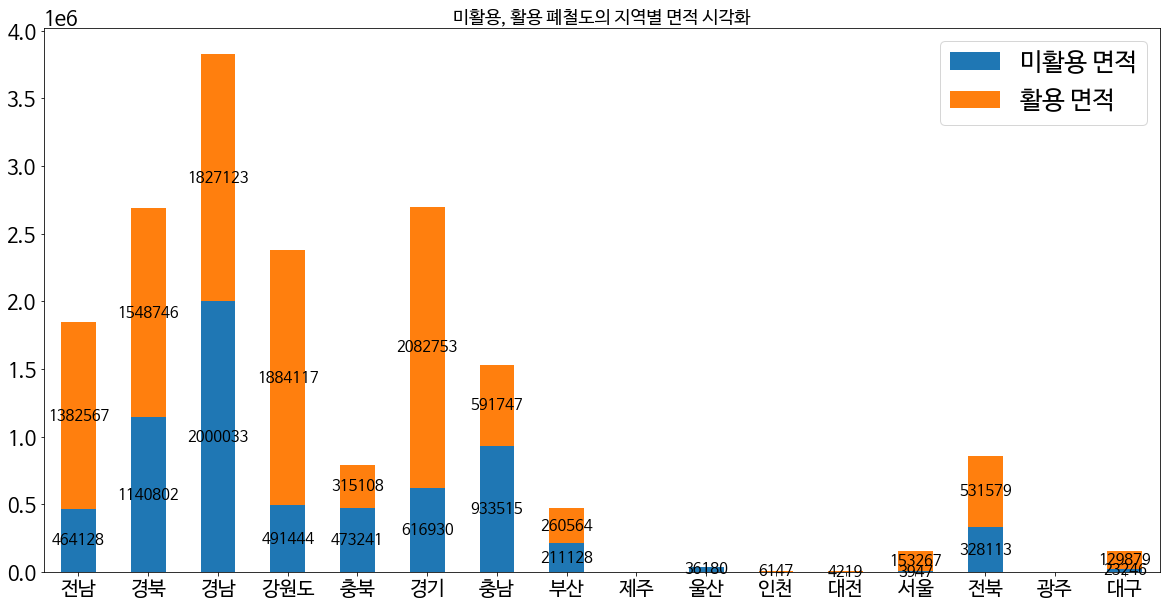

In [46]:
# 그래프 시각화
x = list(Y_train_area.keys())
data = {                           
    "미활용 면적": N_train_area.values(),
    "활용 면적": Y_train_area.values()
}

df = pd.DataFrame(data,index=x)
colors = sns.color_palette('hls',len(x)) # 색상 지정

plt.rc('font', family='NanumBarunGothic') 
ax = df.plot(stacked=True, kind='bar',figsize=(20,10))
ax.set_xticklabels(x,rotation='horizontal')

plt.rc('font', size=15)        # 기본 폰트 크기
plt.rc('axes', labelsize=10)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기

for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    label_text = height
    label_x = x + width / 2
    label_y = y + height / 2

    if label_text == 0: continue

    ax.text(label_x, label_y, int(label_text), ha='center',    
            va='center')
    
plt.title('미활용, 활용 폐철도의 지역별 면적 시각화')
plt.show()


## 서울시 자투리 땅

In [47]:
leftover.columns=['연번','소재지','재산종류','면적(㎡)','지목','비고']
leftover.drop([0],axis=0,inplace=True)
leftover['면적(㎡)']=leftover['면적(㎡)'].astype('float')


In [48]:
useLeftover=leftover[leftover['지목']=='유휴건물']
useLeftover

,연번,소재지,재산종류,면적(㎡),지목,비고
145,145,서울시 서초구 서초동 391,건물,29.40,유휴건물,소방학교(본부/경비실)
146,146,서울시 서초구 서초동 391,건물,2539.15,유휴건물,소방학교(본부/생활관)
147,147,서울시 서초구 서초동 391,건물,1230.88,유휴건물,소방학교(본부/훈련탑)
148,148,서울시 서초구 서초동 산36,건물,4152.07,유휴건물,소방학교(본관)
149,149,서울시 송파구 가락동 161,건물,5011.15,유휴건물,숙영시설
150,150,서울시 송파구 가락동 161,건물,136.50,유휴건물,경비실
151,151,서울시 송파구 가락동 161,건물,70.00,유휴건물,창고


In [49]:
useLeftArea=useLeftover['면적(㎡)'].sum()
useLeftArea

13169.15

In [50]:
leftarea=leftover['면적(㎡)'].sum()
leftarea

20384.55

## 전체 유휴부지 면적 시각화

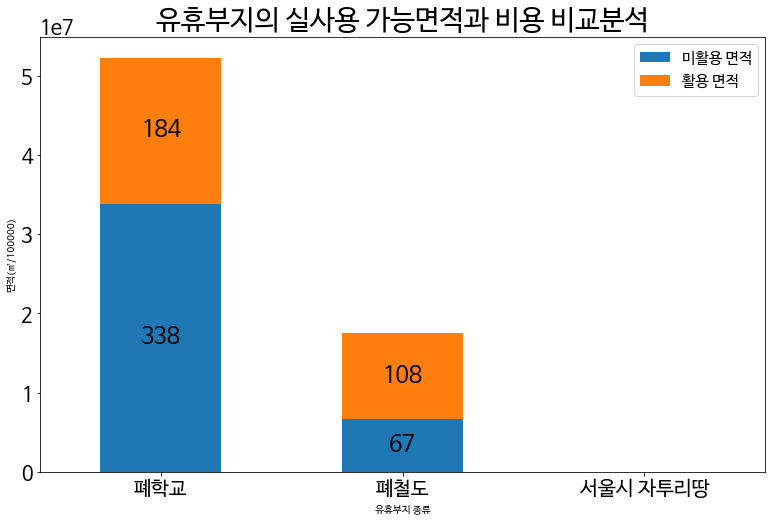

In [51]:
x = ['폐학교','폐철도','서울시 자투리땅'] #'댐', '서울시 자투리땅']
data = {                           
    "미활용 면적": [NotUse_school_area, NotUse_rail_area,useLeftArea],
    "활용 면적": [Use_school_area, Use_rail_area,leftarea]
}

df = pd.DataFrame(data,index=x)
colors = sns.color_palette('hls',len(x)) # 색상 지정

plt.rc('font', family='NanumBarunGothic') 
ax = df.plot(stacked=True, kind='bar',figsize=(13,8))
ax.set_xticklabels(x,rotation='horizontal')

plt.rc('font', size=23)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기

plt.title('유휴부지의 실사용 가능면적과 비용 비교분석')
for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    label_text = height/100000
    label_x = x + width / 2
    label_y = y + height / 2

    if label_text<10: 
      continue
    else:
      ax.text(label_x, label_y, int(label_text), ha='center',    
            va='center')

ax.set_xlabel('유휴부지 종류')
ax.set_ylabel('면적(㎡/100000)')
plt.rcParams['font.size'] = '16'
plt.show()


# 수요 대비 공급, 생산 전력 지도 시각화

In [57]:
Map_geo = json.load(open('./TL_SCCO_CTPRVN.json',encoding='utf-8')) # json geo 파일 불러들이기
df_installation = pd.read_csv('./20220629_태양광+발전소+누적+실치현황.csv')
df_power_generation = pd.read_csv('./20220623_2021년+신규+발전량+현황.csv')
df_ac_mon = pd.read_csv('./data_ac_mon.csv',encoding='cp949')

## 수요 대비 공급 지도 시각화

In [58]:
# json파일 지역과 똑같도록 구분 col을 바꾼다.
region = ['서울','부산','대구','인천','광주','대전','울산','세종','경기','강원','충청북도','충청남도','전라북도','전라남도','경상북도','경상남도','제주']

All_Sum = list() 
for i in range(len(df_power_generation)):    # 12개월을 모두 합친 연간 총 전력 발전량 구하기
    Sum = 0
    for j in range(1,13):
        Sum += float(re.sub(',','',df_power_generation.iloc[i,j]))
    All_Sum.append(int(Sum))

df_power_generation['2021 신규 태양광 발전량'] = All_Sum

for i in range(len(df_power_generation)):
  df_power_generation.loc[i,'구분'] = region[i]

df_power_generation

,구분,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월,2021 신규 태양광 발전량
0,서울,"3,034.95","3,980.64","4,907.55","5,397.13","5,047.46","4,988.7","5,118.98","4,072.12","4,614.26","3,995.58","3,253.8","3,243.29",51654
1,부산,"10,180.04","11,687.18","14,465.87","18,000","16,325.32","16,162.96","15,854.89","13,345.26","11,193.58","14,637.56","12,591.54","12,615.43",167059
2,대구,"7,612.01","8,604.72","10,252.53","12,445.39","11,973.45","11,773.01","12,303.42","9,821.7","8,793.14","10,527.74","8,680.15","8,980.62",121767
3,인천,"6,747.24","8,403.46","10,827.66","12,019.95","11,675.47","11,307.62","11,824.01","9,216.13","9,940.06","8,752.92","6,656.17","6,704.51",114075
4,광주,"10,735.14","16,070.55","23,853.83","27,073.72","26,813.96","26,115.24","24,456.06","22,480.3","19,551.06","22,569.82","16,417.78","14,562.32",250699
5,대전,"2,145.22","3,001.15","3,706.24","4,351.98","3,962.23","4,239.96","4,499.87","3,462.21","3,514.94","3,667.56","2,734.68","2,587.77",41873
6,울산,"5,691.22","6,663.84","7,711.13","9,333.92","8,745.09","8,291","8,204.16","6,654.68","5,791.38","7,202.58","6,580.49","6,708.67",87578
7,세종,"3,098.09","4,435.98","5,640.61","6,609.69","6,267.46","6,477.4","6,801.4","5,120.37","5,557.56","5,397.9","4,018.18","3,710.69",63135
8,경기,"66,523.6","85,818.9","112,186.93","126,270.27","121,221.03","124,620.6","133,500.53","101,920.7","109,705.69","98,706.69","76,210.66","76,515.11",1233200
9,강원,"89,760.12","121,608.83","143,203.34","168,144.47","158,552.07","156,917.38","175,358.42","122,169.18","134,240.22","120,289.57","106,212.54","100,052.08",1596508


In [59]:
# json 파일의 지역과 순서가 같도록 전처리

location, temp = list(), list()

for idx,dic in enumerate(Map_geo['features']):
  for i in range(len(df_power_generation)):
    if df_power_generation.loc[i,'구분'] in dic['properties']['CTP_KOR_NM']:
      location.append(df_power_generation.loc[i,'구분']), temp.append(df_power_generation.loc[i,'2021 신규 태양광 발전량'])

df_power_generation = pd.DataFrame({'구분':location,'발전량':temp})

df_power_generation

,구분,발전량
0,강원,1596508
1,경기,1233200
2,경상남도,1409212
3,경상북도,2639622
4,광주,250699
5,대구,121767
6,대전,41873
7,부산,167059
8,서울,51654
9,세종,63135


In [60]:
# 2021 신규 태양광 발전량 시각화
for idx,dic in enumerate(Map_geo['features']):
    dic['properties'].update({'name':str(df_power_generation.loc[idx,'구분']),'2021 신규 태양광 발전량':str(df_power_generation.loc[idx,'발전량']),'html':str(0)})
    txt = f'<b><h4>{df_power_generation.iloc[idx,0]}</h4></b> 2021 신규 태양광 발전량: {str(df_power_generation .iloc[idx,1])}'   # html로 작성하여 딕셔너리에 넣는다.
    dic['properties']['html'] = txt   



m = folium.Map(
    location=[37.559819, 126.963895],     # 서울의 위도,경도를 중심으로 잡는다.
    tiles='OpenStreetMap',
    zoom_start=7, 
)

cho = folium.Choropleth(
    geo_data=Map_geo,
    data=df_power_generation,
    fill_color='OrRd',
    columns=['구분','발전량'],
    key_on = 'feature.properties.name',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='2021 신규 태양광 발전량'
).add_to(m)

cho.geojson.add_child(folium.features.GeoJsonTooltip(['html'],labels=False))
title_html = '<h3 align="center" style="font-size:20px"><b>2021 신규 태양광 발전량</b></h3>'
m.get_root().html.add_child(folium.Element(title_html))

m

## 폐철도 설치시 생산 전력 지도 시각화

In [61]:
df_ac_mon.drop(columns={'Unnamed: 0'},axis=0,inplace=True)
df_installation = df_installation.loc[:,['구분','누적 발전소 개소(2021년까지)']]   # 필요한 값만 가져온다(시도별 이름, 태양전지 개수)
df_installation.rename(columns={'구분':'name','누적 발전소 개소(2021년까지)':'태양 전지 개수'},inplace=True)


In [62]:
df_installation

,name,태양 전지 개수
0,서울특별시,505
1,부산광역시,527
2,대구광역시,748
3,인천광역시,642
4,광주광역시,1335
5,대전광역시,433
6,울산광역시,368
7,세종특별자치시,344
8,경기도,8226
9,강원도,6963


In [63]:
location, temp = list(), list()

for idx,dic in enumerate(Map_geo['features']):
  for i in range(len(df_installation)):
    if df_installation.loc[i,'name'] in dic['properties']['CTP_KOR_NM']:
      location.append(df_installation.loc[i,'name']), temp.append(df_installation.loc[i,'태양 전지 개수'])

df_installation = pd.DataFrame({'name':location,'태양 전지 개수':temp})

df_installation

,name,태양 전지 개수
0,강원도,6963
1,경기도,8226
2,경상남도,6929
3,경상북도,13820
4,광주광역시,1335
5,대구광역시,748
6,대전광역시,433
7,부산광역시,527
8,서울특별시,505
9,세종특별자치시,344


In [64]:

for idx,dic in enumerate(Map_geo['features']):
    dic['properties'].update({'name':str(df_installation.iloc[idx,0]),'태양 전지 개수':str(df_installation.iloc[idx,1]),'html':str(0)})
    txt = f'<b><h4>{df_installation.iloc[idx,0]}</h4></b>연간 예측 전력 발전량: {str(df_ac_mon.iloc[idx,1])}'   # html로 작성하여 딕셔너리에 넣는다.
    dic['properties']['html'] = txt   
    

m = folium.Map(
    location=[37.559819, 126.963895],     # 서울의 위도,경도를 중심으로 잡는다.
    tiles='OpenStreetMap',
    zoom_start=7, 
)

cho = folium.Choropleth(
    geo_data=Map_geo,
    data=df_ac_mon,
    fill_color='OrRd',
    columns=['주소','ac_annual'],
    key_on = 'feature.properties.name',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='연간 예측 전략 발전량'
).add_to(m)

cho.geojson.add_child(folium.features.GeoJsonTooltip(['html'],labels=False))
title_html = '<h3 align="center" style="font-size:20px"><b>연간 예측 전략 발전량</b></h3>'
m.get_root().html.add_child(folium.Element(title_html))

m

# 국내 폐철도의 위치 분석

In [65]:
# 폐철도 지도 표시

df = pd.read_csv('./location.csv')

fig = px.density_mapbox(df, lat='lat', lon='lng', radius=3,      # 우리나라 위경도를 지도위에 표시한다.
                        center=dict(lat=37.559819, lon=126.963895), zoom=5,
                        )
fig.update_layout(     # 지도 꾸미기
    mapbox_style="white-bg", 
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "source": [
                "https://api.vworld.kr/req/wmts/1.0.0/5442922B-39B0-355B-B773-7113F506F982/Satellite/{z}/{y}/{x}.jpeg"
            ]
            
        },
        {
            "sourcetype": "raster",
            "source": [
                "https://api.vworld.kr/req/wmts/1.0.0/5442922B-39B0-355B-B773-7113F506F982/Hybrid/{z}/{y}/{x}.png"
            ]

        }
      ])
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

# 국내 폐철도의 연간 예측 태양 일사량, 발전량 지도 시각화

In [68]:
Nrel_df = pd.read_csv('./Nrel_alldata.csv',encoding='cp949')
Nrel_df.rename(columns={'solrad_annual':'solrad_annual(kWh/m2/day)'},inplace=True)
Nrel_df.rename(columns={"ac_annual":"연간 예측 전력발전량(kWh)"},inplace = True)
Nrel_df['연간 예측 전력발전량(kWh)'] = Nrel_df['연간 예측 전력발전량(kWh)'].astype(int)
px.set_mapbox_access_token(open("./mapbox_token.py").read()) # 지도 api 사용

## 예측 태양 일사량

In [69]:
# 연간 태양 일사량 지도 표시
fig = px.scatter_mapbox(df1, lat="lat", lon="lng", color='solrad_annual(kWh/m2/day)',hover_name="주소",hover_data=["solrad_annual(kWh/m2/day)","노선명",'면적'],
                        color_continuous_scale=px.colors.cyclical.IceFire,zoom=7
                       )

fig.update_layout(mapbox={'style':'dark','zoom':7},showlegend=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## 예측 전력 발전량

In [70]:
# 연간 예측 전력발전량 지도 표시
fig = px.scatter_mapbox(df2, lat="lat", lon="lng", color='연간 예측 전력발전량(kWh)',hover_name="주소",hover_data=["연간 예측 전력발전량(kWh)",'면적'],
                        color_continuous_scale=px.colors.sequential.Viridis,zoom=7
                       )

fig.update_layout(mapbox={'style':'dark','zoom':7},showlegend=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()



Output hidden; open in https://colab.research.google.com to view.

# 노선별 예측 전력 생산량 시각화

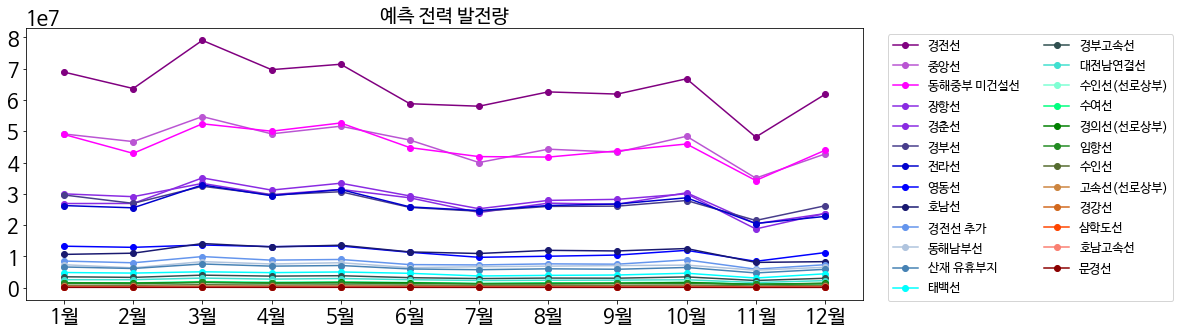

In [71]:
Mon = ['1월','2월','3월','4월','5월','6월','7월','8월','9월','10월','11월','12월','노선명']
df = pd.read_csv("./Nrel_alldata.csv",encoding='cp949')
df_ac_mon = df.iloc[:,1:13]
df_ac_mon['노선명'] = df.loc[:,'노선명']
df_ac_mon.columns = Mon

df_ac_mon = df_ac_mon.groupby('노선명').sum().astype(int)

All_sum = list()

for i in range(len(df_ac_mon)):     # 범례를 순서대로 하기 위해 총 발전량을 계산한다.
    Sum = 0
    for j in range(12):
        Sum += df_ac_mon.iloc[i,j]
    All_sum.append(Sum)
    

df_ac_mon['총 발전량'] = All_sum   # 총 발전량을 기준으로 정렬하고 총 발전량을 삭제한다.
df_ac_mon.sort_values(by='총 발전량',ascending=False,inplace=True)
df_ac_mon.drop(columns={'총 발전량'},inplace=True)        

x = list(df_ac_mon.columns)
plt.figure(figsize=(15,5))

name = df_ac_mon.index
color = ['purple','mediumorchid','magenta','blueviolet','blueviolet','darkslateblue','mediumblue','b','midnightblue','cornflowerblue','lightsteelblue','steelblue','aqua','darkslategray','turquoise'
         ,'aquamarine','springgreen','green','forestgreen','darkolivegreen','peru','chocolate','orangered','salmon','darkred']


for i in range(len(df_ac_mon)):
    y = list(df_ac_mon.loc[name[i]])
    plt.plot(x,y,'o-',color = color[i])


plt.title('예측 전력 발전량')

plt.rc('font', size=10)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=14)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=30)  # 범례 폰트 크기

plt.legend(name,loc='upper center', ncol=2,fontsize=12.5,bbox_to_anchor=(1.2, 1))
plt.show()

# Top7 예측 전력 발전량과 면적 시각화

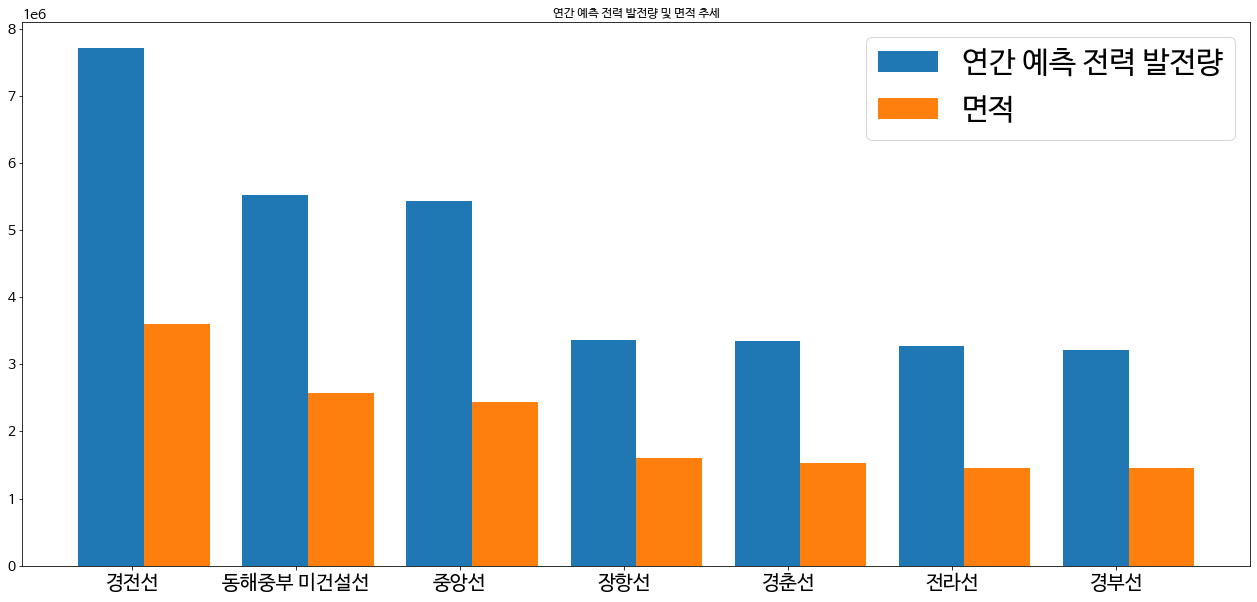

In [72]:
# 연간 예측 전력 발전량, 면적 그래프 표현

Area_Data = pd.read_csv('./train_area.csv')
Rail_Data = pd.read_csv('./Nrel_alldata.csv',encoding='cp949')

Mon = ['노선명','1월','2월','3월','4월','5월','6월','7월','8월','9월','10월','11월','12월']

Rail_D = Rail_Data.loc[:,['ac_annual','노선명']]
Rail_D = Rail_D.groupby('노선명').sum().astype(int)
Rail_D = Rail_D.sort_values(by='ac_annual',ascending=False)


Area_Data = Area_Data.sort_values(by='면적',ascending=False)

x1 = list(Area_Data.iloc[0:7,1])
y1 = list(Area_Data.iloc[0:7,2])

x2 = list(Rail_D.index)
x2 = x2[:7]
y2 = list(Rail_D.iloc[0:7,0] / 100)

x2[1],x2[2] = x2[2],x2[1]     # 연간 예측 발전량과 면적의 노선명이 같도록 전처리
x2[6],x2[5] = x2[5],x2[6]

plt.figure(figsize=(22,10))
plt.bar([i * 2 for i in range(len(x2))], y2, label='연간 예측 전력 발전량')
plt.bar([i * 2 + 0.8 for i in range(len(x2))], y1, label='면적')
plt.xticks([i * 2 + 0.25 for i in range(len(x2))], x2)

plt.title('연간 예측 전력 발전량 및 면적 추세')
plt.legend(['연간 예측 전력 발전량','면적'])
plt.show()



# 현실성 분석-활용가능한 철도 고려

## 폐철도의 노선별 활용여부 시각화

In [118]:
data=pd.read_csv('./Nrel_alldata.csv',encoding='cp949')

data

,Unnamed: 0,ac_monthly_1,ac_monthly_2,ac_monthly_3,ac_monthly_4,ac_monthly_5,ac_monthly_6,ac_monthly_7,ac_monthly_8,ac_monthly_9,...,solared_mon_11,solared_mon_12,solrad_annual,ac_annual,주소,lat,lng,노선명,면적,활용여부
0,0,4057.915527,3759.287354,4843.357910,4177.175781,4383.065918,4058.536133,3643.001709,4111.915527,3566.978760,...,3.419215,3.690041,4.991238,46336.46094,경기도 이천시 부발읍 아미리 35-25,37.261240,127.509591,경강선,207,잔여지
1,1,22994.837890,21302.613280,27445.679690,23670.673830,24837.386720,22998.361330,20643.666020,23300.835940,20212.888670,...,3.419215,3.690041,4.991238,262573.28130,경기도 이천시 부발읍 아미리 산47-4,37.264084,127.504588,경강선,1173,잔여지
2,2,6043.421387,5528.490234,6819.777344,6156.203613,6444.708984,5975.625488,4937.916504,5952.940430,5171.538086,...,4.321303,4.556433,5.090991,69401.57031,경기도 여주군 능서면 용은리 452-7,37.285921,127.540261,경강선,303,잔여지
3,3,5422.337402,5304.317383,6449.504883,5607.563477,5758.562988,5216.856934,4790.609863,4348.856445,4614.077637,...,3.622517,3.602298,4.927883,60532.85156,경기도 광주시 삼동 222-8,37.409898,127.205004,경강선,272,잔여지
4,4,4066.753418,3978.236084,4837.125488,4205.672363,4318.919922,3912.643066,3592.956055,3261.640869,3460.559082,...,3.622517,3.602298,4.927883,45399.64063,경기도 광주시 장지동 496-7,37.405114,127.238558,경강선,204,잔여지
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18966,18966,21303.392580,19975.484380,24107.361330,21667.039060,22700.412110,18703.416020,16212.179690,18224.779300,19139.033200,...,3.484469,4.146350,5.015473,232793.75000,경상북도 김천시 남면 옥산리 800,36.112589,128.182986,경부고속선,1036,미사용(나대지)
18967,18967,16800.070310,15752.860350,19011.316410,17086.833980,17901.767580,14749.691410,12785.088870,14372.247070,15093.236330,...,3.484469,4.146350,5.015473,183583.50000,경상북도 김천시 남면 옥산리 928-17,36.112883,128.183066,경부고속선,817,미사용(나대지)
18968,18968,48679.578130,44671.890630,56794.652340,52491.355470,59011.511720,49473.902340,41056.343750,49578.003910,45075.156250,...,3.249641,4.508086,5.003201,573747.75000,충청북도 청주시 흥덕구 오송읍 봉산리 36-15,36.622411,127.329938,경부고속선,2549,사용_철도사업(오송창고)
18969,18969,5671.967773,5205.003906,6617.500488,6116.100586,6875.800781,5764.512695,4783.731934,5776.647949,5251.991699,...,3.249641,4.508086,5.003201,66850.95313,충청북도 청주시 흥덕구 오송읍 봉산리 43-2,36.622051,127.329364,경부고속선,297,사용_철도사업(오송창고)


In [119]:
data['노선명'].unique()

array(['경강선', '경부선', '경춘선', '수여선', '수인선', '중앙선', '경부고속선', '경전선', '동해남부선',
       '동해중부 미건설선', '산재 유휴부지', '임항선', '대전남연결선', '문경선', '장항선', '경전선 추가',
       '삼학도선', '전라선', '호남선', '영동선', '태백선', '수인선(선로상부)', '경의선(선로상부)',
       '고속선(선로상부)', '호남고속선'], dtype=object)

In [120]:
# 우선 데이터중 사용가능한 부지와 사용 불가능한 부지로 분리하고 그 중에서 통계를 내야겠다.
Available_Section=data[data['활용여부']=='미사용'] # Avail은 미사용중인 철도의 면적
unAvailable_Section=data[data['활용여부']!='미사용']


In [121]:
# 미사용중인 경부고속선 개수

Available_Section[Available_Section['노선명'] == '경부고속선'].count()

Unnamed: 0        1
ac_monthly_1      1
ac_monthly_2      1
ac_monthly_3      1
ac_monthly_4      1
ac_monthly_5      1
ac_monthly_6      1
ac_monthly_7      1
ac_monthly_8      1
ac_monthly_9      1
ac_monthly_10     1
ac_monthly_11     1
ac_monthly_12     1
solared_mon_1     1
solared_mon_2     1
solared_mon_3     1
solared_mon_4     1
solared_mon_5     1
solared_mon_6     1
solared_mon_7     1
solared_mon_8     1
solared_mon_9     1
solared_mon_10    1
solared_mon_11    1
solared_mon_12    1
solrad_annual     1
ac_annual         1
주소                1
lat               1
lng               1
노선명               1
면적                1
활용여부              1
dtype: int64

In [122]:
# 사용중인 경부고속선 개수
unAvailable_Section[unAvailable_Section['노선명'] == '경부고속선'].count()

Unnamed: 0        99
ac_monthly_1      99
ac_monthly_2      99
ac_monthly_3      99
ac_monthly_4      99
ac_monthly_5      99
ac_monthly_6      99
ac_monthly_7      99
ac_monthly_8      99
ac_monthly_9      99
ac_monthly_10     99
ac_monthly_11     99
ac_monthly_12     99
solared_mon_1     99
solared_mon_2     99
solared_mon_3     99
solared_mon_4     99
solared_mon_5     99
solared_mon_6     99
solared_mon_7     99
solared_mon_8     99
solared_mon_9     99
solared_mon_10    99
solared_mon_11    99
solared_mon_12    99
solrad_annual     99
ac_annual         99
주소                99
lat               99
lng               99
노선명               99
면적                99
활용여부              99
dtype: int64

In [123]:
availTrain=Available_Section['노선명'].unique()
availTrain

array(['경춘선', '중앙선', '경부선', '경전선', '동해남부선', '동해중부 미건설선', '산재 유휴부지', '장항선',
       '삼학도선', '전라선', '호남선', '영동선', '태백선', '경부고속선'], dtype=object)

In [124]:
unAvailTrain=unAvailable_Section['노선명'].unique()
unAvailTrain

array(['경강선', '경부선', '경춘선', '수여선', '수인선', '중앙선', '경부고속선', '경전선', '동해남부선',
       '동해중부 미건설선', '산재 유휴부지', '임항선', '대전남연결선', '문경선', '장항선', '경전선 추가',
       '전라선', '호남선', '영동선', '수인선(선로상부)', '경의선(선로상부)', '고속선(선로상부)',
       '호남고속선'], dtype=object)

In [125]:
# 아래 개수를 보면 미사용중인 철도는 23/25개의 철도이고 사용중인 철도는 14/25임을 확인할 수 있다
print(len(availTrain))
print(len(unAvailTrain))

14
23


In [126]:
# 활용 가능한 철도와 불가능한 철도의 교집합/차집합 구하기
print('교집합: ',set(availTrain) & set(unAvailTrain))
print('차집합: ',set(availTrain) | set(unAvailTrain))

교집합:  {'경춘선', '동해중부 미건설선', '전라선', '호남선', '중앙선', '동해남부선', '경부선', '영동선', '경전선', '산재 유휴부지', '장항선', '경부고속선'}
차집합:  {'경춘선', '수인선(선로상부)', '중앙선', '고속선(선로상부)', '영동선', '수인선', '산재 유휴부지', '대전남연결선', '경전선 추가', '경부고속선', '문경선', '수여선', '호남선', '경강선', '태백선', '동해중부 미건설선', '동해남부선', '임항선', '전라선', '경부선', '경전선', '삼학도선', '호남고속선', '경의선(선로상부)', '장항선'}


In [127]:
# 사용 가능 - 미사용중
Available_Section = Available_Section[['노선명','면적','활용여부']]
Available_Section


,노선명,면적,활용여부
1494,경춘선,23,미사용
1500,경춘선,17,미사용
1501,경춘선,13,미사용
1502,경춘선,10,미사용
1506,경춘선,81,미사용
...,...,...,...
18745,태백선,466,미사용
18746,태백선,457,미사용
18747,태백선,104,미사용
18748,태백선,22,미사용


In [128]:
# 사용 불가 - 사용중
unAvailable_Section = unAvailable_Section[['노선명','면적','활용여부']]
unAvailable_Section

,노선명,면적,활용여부
0,경강선,207,잔여지
1,경강선,1173,잔여지
2,경강선,303,잔여지
3,경강선,272,잔여지
4,경강선,204,잔여지
...,...,...,...
18966,경부고속선,1036,미사용(나대지)
18967,경부고속선,817,미사용(나대지)
18968,경부고속선,2549,사용_철도사업(오송창고)
18969,경부고속선,297,사용_철도사업(오송창고)


In [129]:
print(len(unAvailable_Section))

9823


In [130]:
# 잘 분리되었는지 개수로 확인
print('원본 데이터의 개수:',len(data))
print('활용 불가능한(사용중) 데이터의 개수:',len(unAvailable_Section))
print('활용 가능한 데이터의 개수:',len(Available_Section))
print('사용 가능+불가능 데이터: ',len(unAvailable_Section)+len(Available_Section))

원본 데이터의 개수: 18971
활용 불가능한(사용중) 데이터의 개수: 9823
활용 가능한 데이터의 개수: 9148
사용 가능+불가능 데이터:  18971


In [131]:
# Available_Section(미사용중), notAvailable_Section(사용중)을 각각 구분하여 철도별로 그룹화
Available_group=Available_Section.groupby('노선명')
unAvailable_group=unAvailable_Section.groupby('노선명') # df.gruptby('칼럼명')시 해당 칼럼

In [132]:
Available_group

In [133]:
# 아래 예시와 같이 그룹화한 객체에 .get_group()으로 카테고리 값을 입력시 그 값에 해당하는 행들만 불러와줌
train1=Available_group.get_group('경부고속선')

In [134]:
train1['활용여부'].unique()

array(['미사용'], dtype=object)

In [135]:
train_name = ['경강선', '경부선', '경춘선', '수여선', '수인선', '중앙선', '경부고속선', '경전선', '동해남부선',
     '동해중부 미건설선', '산재 유휴부지', '임항선', '대전남연결선', '문경선', '장항선', '경전선 추가',
     '삼학도선', '전라선', '호남선', '영동선', '태백선', '수인선(선로상부)', '경의선(선로상부)',
     '고속선(선로상부)', '호남고속선']

# 사용 가능한 부지의 노선별 면적합 구하기
def calc_avail_areaSum(all_train):  
  area_sum=[]
  for i in range(25):
    try:
      # 노선별로 분리하고 합계를 구한다
      train_obj=Available_group.get_group(train_name[i])
      # 노선별 면적의 합을 구하고 리스트에 append()
      area_sum.append(train_obj['면적'].sum())

    except:   
      area_sum.append(0);

    
  # 다 구해졌으면 노선별 면적합을 Series 형태로 반환 
  area_df=pd.Series(area_sum,index=all_train)
  return area_df

# 사용 불가능한 부지의 노선별 면적합 구하기
def calc_Unavail_areaSum(all_train): 
  area_sum=[]
  train_obj=0
  for i in range(25):
      try:
        # 노선별로 분리하고 합계를 구한다
        train_obj=unAvailable_group.get_group(train_name[i])
        # 노선별 면적의 합을 구하고 리스트에 append()
        area_sum.append(train_obj['면적'].sum())
      except:   
        area_sum.append(0);

  area_df=pd.Series(area_sum,index=all_train)
  return area_df

In [136]:
all_train=['경강선', '경부선', '경춘선', '수여선', '수인선', '중앙선', '경부고속선', '경전선', '동해남부선',
     '동해중부 미건설선', '산재 유휴부지', '임항선', '대전남연결선', '문경선', '장항선', '경전선 추가',
     '삼학도선', '전라선', '호남선', '영동선', '태백선', '수인선(선로상부)', '경의선(선로상부)',
     '고속선(선로상부)', '호남고속선']

Avail_area_sum=calc_avail_areaSum(all_train)
unAvail_area_sum=calc_Unavail_areaSum(all_train)

In [137]:
# 미활용
Avail_area_sum

경강선                0
경부선           320736
경춘선            32012
수여선                0
수인선                0
중앙선           870214
경부고속선           6934
경전선          1840496
동해남부선         220839
동해중부 미건설선    1266197
산재 유휴부지       204791
임항선                0
대전남연결선             0
문경선                0
장항선           933515
경전선 추가             0
삼학도선           11511
전라선           362858
호남선           417872
영동선             4443
태백선           230289
수인선(선로상부)          0
경의선(선로상부)          0
고속선(선로상부)          0
호남고속선              0
dtype: int64

In [138]:
# 활용중
unAvail_area_sum

경강선            12028
경부선          1119911
경춘선          1454825
수여선            79599
수인선            38634
중앙선          1562991
경부고속선         165640
경전선          1577321
동해남부선         153770
동해중부 미건설선    1199080
산재 유휴부지       129817
임항선            71922
대전남연결선        131855
문경선             4109
장항선           574142
경전선 추가        434361
삼학도선               0
전라선          1078118
호남선           209757
영동선           612653
태백선                0
수인선(선로상부)      84005
경의선(선로상부)      76254
고속선(선로상부)      21708
호남고속선           9463
dtype: int64

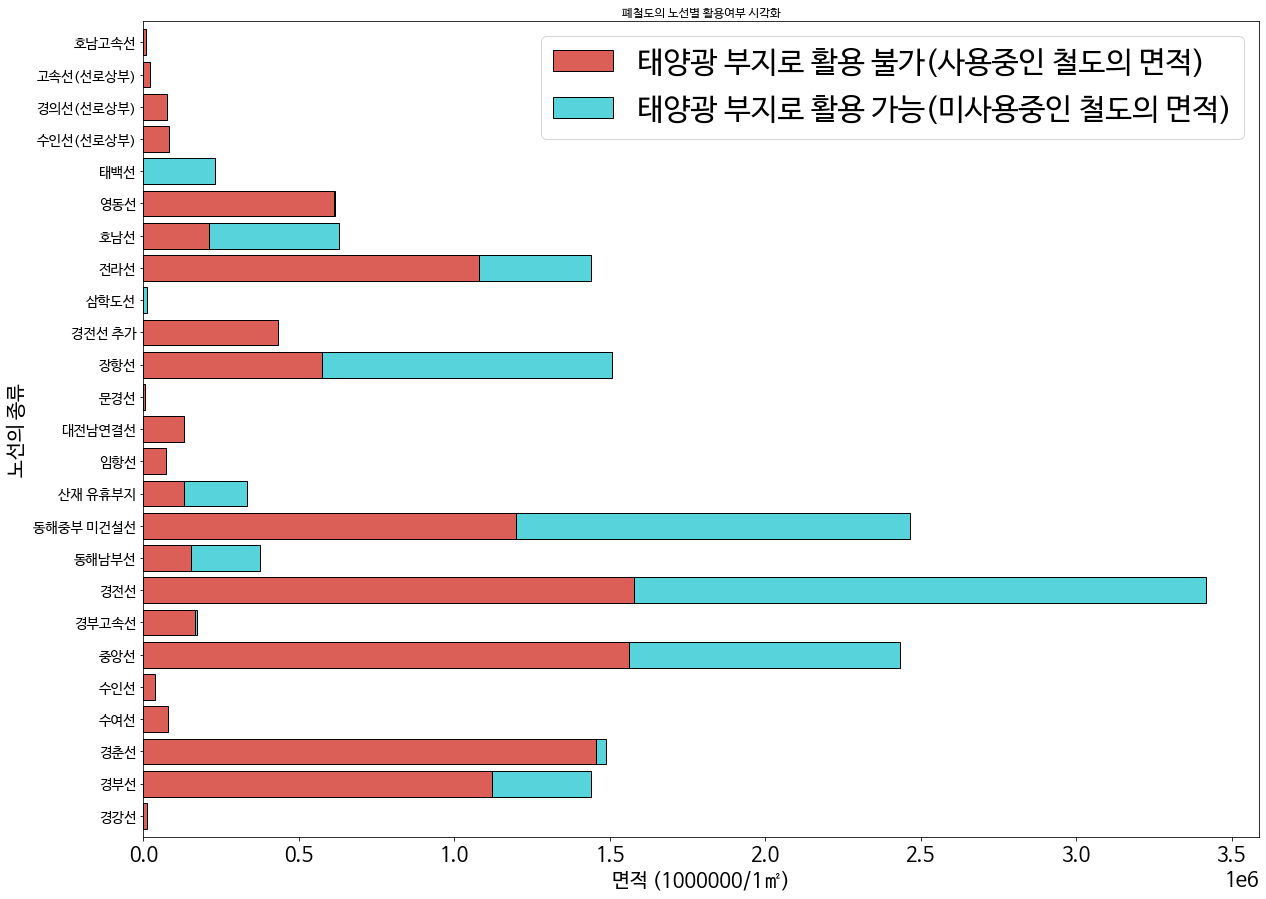

In [139]:
all_train=['경강선', '경부선', '경춘선', '수여선', '수인선', '중앙선', '경부고속선', '경전선', '동해남부선',
     '동해중부 미건설선', '산재 유휴부지', '임항선', '대전남연결선', '문경선', '장항선', '경전선 추가',
     '삼학도선', '전라선', '호남선', '영동선', '태백선', '수인선(선로상부)', '경의선(선로상부)',
     '고속선(선로상부)', '호남고속선']

data={
    "태양광 부지로 활용 불가(사용중인 철도의 면적)": unAvail_area_sum.values,
    "태양광 부지로 활용 가능(미사용중인 철도의 면적)": Avail_area_sum.values
}


# 색상 및 사이즈 설정
plt.rc('font', family='NanumBarunGothic') 
#plt.rcParams["figure.figsize"] = (10, 20)
colors = sns.color_palette('hls',2)
df=pd.DataFrame(data,index=all_train)
df.plot(kind='barh',stacked=True,figsize=(20,15),width=0.8,edgecolor='black',color=colors)
plt.title('폐철도의 노선별 활용여부 시각화')
plt.ylabel('노선의 종류')
plt.xlabel('면적 (1000000/1㎡)')
plt.show()

## 폐철도의 전력 생산량 시각화를 통한 철도별 효율 비교

In [167]:
elect=pd.read_csv('Nrel_alldata.csv',encoding='cp949')

In [168]:
group_elect=elect.groupby('노선명').sum().astype('float')
group_elect

,Unnamed: 0,ac_monthly_1,ac_monthly_2,ac_monthly_3,ac_monthly_4,ac_monthly_5,ac_monthly_6,ac_monthly_7,ac_monthly_8,ac_monthly_9,...,solared_mon_8,solared_mon_9,solared_mon_10,solared_mon_11,solared_mon_12,solrad_annual,ac_annual,lat,lng,면적
노선명,,,,,,,,,,,,,,,,,,,,,
경강선,465.0,2.377293e+05,2.198047e+05,2.765273e+05,2.439852e+05,2.552996e+05,2.355988e+05,2.051484e+05,2.336020e+05,2.063996e+05,...,163.967285,148.257380,158.410408,113.968998,124.236155,155.228405,2.704572e+06,1155.871578,3952.356569,12028.0
경부고속선,1862278.0,3.460110e+06,3.273865e+06,3.985379e+06,3.670350e+06,3.805647e+06,3.181410e+06,2.891131e+06,3.051551e+06,3.011641e+06,...,483.681070,479.852084,527.959595,350.383601,434.377216,502.190533,3.900956e+07,3616.701043,12797.421821,172574.0
경부선,7098088.0,2.962547e+07,2.694223e+07,3.241347e+07,2.961853e+07,3.066404e+07,2.563436e+07,2.441896e+07,2.597271e+07,2.605339e+07,...,7101.657898,7199.889065,7350.893308,5745.896851,6516.904884,7261.107110,3.268263e+08,51399.775353,185318.093900,1440647.0
경의선(선로상부),583203.0,1.489507e+06,1.433731e+06,1.653267e+06,1.488264e+06,1.658199e+06,1.518850e+06,1.220841e+06,1.229722e+06,1.396332e+06,...,134.750795,156.789917,173.567211,110.235076,138.806520,153.510674,1.714188e+07,1164.744033,3934.107917,76254.0
경전선,27304412.0,6.892759e+07,6.367373e+07,7.907827e+07,6.970636e+07,7.143588e+07,5.880882e+07,5.801719e+07,6.259122e+07,6.189532e+07,...,18607.286259,18786.166184,19111.233177,13887.225224,16730.770929,18605.751845,7.708485e+08,129416.454864,471677.964502,3417817.0
경전선 추가,7431925.0,8.490917e+06,7.937103e+06,9.927537e+06,8.783530e+06,9.001722e+06,7.352759e+06,7.256973e+06,7.598603e+06,7.493864e+06,...,2553.176001,2519.968483,2873.492078,1941.954507,2220.221512,2606.276209,9.593830e+07,18548.230007,67675.751146,434361.0
경춘선,1830170.0,2.998268e+07,2.908410e+07,3.332150e+07,2.973682e+07,3.139708e+07,2.871927e+07,2.400980e+07,2.700907e+07,2.665957e+07,...,9110.648180,9148.176366,9843.735578,6682.264107,7341.824375,9194.757218,3.343563e+08,69611.676799,235015.746759,1486837.0
고속선(선로상부),489879.0,4.299814e+05,3.951077e+05,4.899869e+05,4.406209e+05,4.838157e+05,4.311316e+05,3.765162e+05,3.973535e+05,4.059533e+05,...,130.176412,134.188067,135.633507,86.948064,123.427449,131.605271,4.977794e+06,971.099193,3298.686541,21708.0
대전남연결선,2184273.0,2.530541e+06,2.526194e+06,3.042454e+06,2.712798e+06,2.910046e+06,2.525328e+06,2.269457e+06,2.356015e+06,2.384758e+06,...,892.861343,926.551367,912.440309,601.053306,772.074060,911.800695,2.962868e+07,6601.892144,23217.686542,131855.0


In [169]:
group_elect=group_elect[['면적','ac_annual']]
group_elect

,면적,ac_annual
노선명,,
경강선,12028.0,2.704572e+06
경부고속선,172574.0,3.900956e+07
경부선,1440647.0,3.268263e+08
경의선(선로상부),76254.0,1.714188e+07
경전선,3417817.0,7.708485e+08
경전선 추가,434361.0,9.593830e+07
경춘선,1486837.0,3.343563e+08
고속선(선로상부),21708.0,4.977794e+06
대전남연결선,131855.0,2.962868e+07


In [170]:
power=pd.read_csv('Nrel_alldata.csv',encoding='cp949')

In [171]:
power.columns

Index(['Unnamed: 0', 'ac_monthly_1', 'ac_monthly_2', 'ac_monthly_3',
       'ac_monthly_4', 'ac_monthly_5', 'ac_monthly_6', 'ac_monthly_7',
       'ac_monthly_8', 'ac_monthly_9', 'ac_monthly_10', 'ac_monthly_11',
       'ac_monthly_12', 'solared_mon_1', 'solared_mon_2', 'solared_mon_3',
       'solared_mon_4', 'solared_mon_5', 'solared_mon_6', 'solared_mon_7',
       'solared_mon_8', 'solared_mon_9', 'solared_mon_10', 'solared_mon_11',
       'solared_mon_12', 'solrad_annual', 'ac_annual', '주소', 'lat', 'lng',
       '노선명', '면적', '활용여부'],
      dtype='object')

In [172]:
power

,Unnamed: 0,ac_monthly_1,ac_monthly_2,ac_monthly_3,ac_monthly_4,ac_monthly_5,ac_monthly_6,ac_monthly_7,ac_monthly_8,ac_monthly_9,...,solared_mon_11,solared_mon_12,solrad_annual,ac_annual,주소,lat,lng,노선명,면적,활용여부
0,0,4057.915527,3759.287354,4843.357910,4177.175781,4383.065918,4058.536133,3643.001709,4111.915527,3566.978760,...,3.419215,3.690041,4.991238,46336.46094,경기도 이천시 부발읍 아미리 35-25,37.261240,127.509591,경강선,207,잔여지
1,1,22994.837890,21302.613280,27445.679690,23670.673830,24837.386720,22998.361330,20643.666020,23300.835940,20212.888670,...,3.419215,3.690041,4.991238,262573.28130,경기도 이천시 부발읍 아미리 산47-4,37.264084,127.504588,경강선,1173,잔여지
2,2,6043.421387,5528.490234,6819.777344,6156.203613,6444.708984,5975.625488,4937.916504,5952.940430,5171.538086,...,4.321303,4.556433,5.090991,69401.57031,경기도 여주군 능서면 용은리 452-7,37.285921,127.540261,경강선,303,잔여지
3,3,5422.337402,5304.317383,6449.504883,5607.563477,5758.562988,5216.856934,4790.609863,4348.856445,4614.077637,...,3.622517,3.602298,4.927883,60532.85156,경기도 광주시 삼동 222-8,37.409898,127.205004,경강선,272,잔여지
4,4,4066.753418,3978.236084,4837.125488,4205.672363,4318.919922,3912.643066,3592.956055,3261.640869,3460.559082,...,3.622517,3.602298,4.927883,45399.64063,경기도 광주시 장지동 496-7,37.405114,127.238558,경강선,204,잔여지
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18966,18966,21303.392580,19975.484380,24107.361330,21667.039060,22700.412110,18703.416020,16212.179690,18224.779300,19139.033200,...,3.484469,4.146350,5.015473,232793.75000,경상북도 김천시 남면 옥산리 800,36.112589,128.182986,경부고속선,1036,미사용(나대지)
18967,18967,16800.070310,15752.860350,19011.316410,17086.833980,17901.767580,14749.691410,12785.088870,14372.247070,15093.236330,...,3.484469,4.146350,5.015473,183583.50000,경상북도 김천시 남면 옥산리 928-17,36.112883,128.183066,경부고속선,817,미사용(나대지)
18968,18968,48679.578130,44671.890630,56794.652340,52491.355470,59011.511720,49473.902340,41056.343750,49578.003910,45075.156250,...,3.249641,4.508086,5.003201,573747.75000,충청북도 청주시 흥덕구 오송읍 봉산리 36-15,36.622411,127.329938,경부고속선,2549,사용_철도사업(오송창고)
18969,18969,5671.967773,5205.003906,6617.500488,6116.100586,6875.800781,5764.512695,4783.731934,5776.647949,5251.991699,...,3.249641,4.508086,5.003201,66850.95313,충청북도 청주시 흥덕구 오송읍 봉산리 43-2,36.622051,127.329364,경부고속선,297,사용_철도사업(오송창고)


In [173]:
power[power['활용여부']=='미사용']

,Unnamed: 0,ac_monthly_1,ac_monthly_2,ac_monthly_3,ac_monthly_4,ac_monthly_5,ac_monthly_6,ac_monthly_7,ac_monthly_8,ac_monthly_9,...,solared_mon_11,solared_mon_12,solrad_annual,ac_annual,주소,lat,lng,노선명,면적,활용여부
1494,1494,468.444061,462.930023,501.905334,469.601288,474.489502,449.245148,377.419311,446.105011,379.761200,...,3.623278,4.613333,5.034738,5.214096e+03,강원도 춘천시 신동면 증리 1040ㅡ9,37.838152,127.731328,경춘선,23,미사용
1500,1500,347.090607,323.723572,375.379394,340.207947,360.066437,329.254822,276.597900,275.382843,328.229675,...,3.667981,3.926075,4.938661,3.792307e+03,강원도 춘천시 신동면 증리 646ㅡ5,37.825466,127.723267,경춘선,17,미사용
1501,1501,265.422394,247.553314,287.054779,260.159119,275.344971,251.782944,211.516113,210.586807,250.999161,...,3.667981,3.926075,4.938661,2.900000e+03,강원도 춘천시 신동면 증리 647ㅡ6,37.825494,127.723284,경춘선,13,미사용
1502,1502,204.170960,190.425644,220.811401,200.122391,211.803894,193.679169,162.704651,161.989883,193.076187,...,3.667981,3.926075,4.938661,2.230769e+03,강원도 춘천시 신동면 증리 657ㅡ1,37.827810,127.725323,경춘선,10,미사용
1506,1506,1649.738403,1630.319214,1767.580200,1653.813232,1671.028320,1582.123047,1329.172852,1571.064575,1337.419556,...,3.623278,4.613333,5.034738,1.836269e+04,강원도 춘천시 신동면 증리 671ㅡ1,37.830312,127.726870,경춘선,81,미사용
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18745,18745,9697.581055,9746.197266,10239.550780,9666.992188,10010.511720,9498.684570,7380.607422,7843.985352,8375.643555,...,3.502862,4.789942,5.072107,1.069582e+05,충청북도 제천시 송학면 무도리 1094ㅡ4,37.185408,128.271539,태백선,466,미사용
18746,18746,9510.287109,9557.968750,10041.796880,9480.287109,9817.180664,9315.237305,7238.063965,7692.490723,8213.881836,...,3.502862,4.789942,5.072107,1.048925e+05,충청북도 제천시 송학면 무도리 1094ㅡ6,37.184292,128.273124,태백선,457,미사용
18747,18747,2164.267334,2175.117188,2285.221924,2157.438721,2234.105469,2119.878906,1647.173096,1750.589233,1869.241455,...,3.502862,4.789942,5.072107,2.387050e+04,충청북도 제천시 송학면 무도리 1096ㅡ1,37.184022,128.263454,태백선,104,미사용
18748,18748,457.825714,460.121033,483.412292,456.381592,472.599213,448.435669,348.440460,370.316864,395.416687,...,3.502862,4.789942,5.072107,5.049529e+03,충청북도 제천시 송학면 무도리 1097ㅡ1,37.181089,128.260589,태백선,22,미사용


In [174]:
use=power[power['활용여부']=='미사용']
notUse=power[power['활용여부']!='미사용']

In [175]:
use=use[['ac_annual','노선명','면적']]
notUse=notUse[['ac_annual','노선명','면적']]

In [176]:
train_perPower=power.groupby('노선명').sum()
train_perPower

,Unnamed: 0,ac_monthly_1,ac_monthly_2,ac_monthly_3,ac_monthly_4,ac_monthly_5,ac_monthly_6,ac_monthly_7,ac_monthly_8,ac_monthly_9,...,solared_mon_8,solared_mon_9,solared_mon_10,solared_mon_11,solared_mon_12,solrad_annual,ac_annual,lat,lng,면적
노선명,,,,,,,,,,,,,,,,,,,,,
경강선,465,2.377293e+05,2.198047e+05,2.765273e+05,2.439852e+05,2.552996e+05,2.355988e+05,2.051484e+05,2.336020e+05,2.063996e+05,...,163.967285,148.257380,158.410408,113.968998,124.236155,155.228405,2.704572e+06,1155.871578,3952.356569,12028
경부고속선,1862278,3.460110e+06,3.273865e+06,3.985379e+06,3.670350e+06,3.805647e+06,3.181410e+06,2.891131e+06,3.051551e+06,3.011641e+06,...,483.681070,479.852084,527.959595,350.383601,434.377216,502.190533,3.900956e+07,3616.701043,12797.421821,172574
경부선,7098088,2.962547e+07,2.694223e+07,3.241347e+07,2.961853e+07,3.066404e+07,2.563436e+07,2.441896e+07,2.597271e+07,2.605339e+07,...,7101.657898,7199.889065,7350.893308,5745.896851,6516.904884,7261.107110,3.268263e+08,51399.775353,185318.093900,1440647
경의선(선로상부),583203,1.489507e+06,1.433731e+06,1.653267e+06,1.488264e+06,1.658199e+06,1.518850e+06,1.220841e+06,1.229722e+06,1.396332e+06,...,134.750795,156.789917,173.567211,110.235076,138.806520,153.510674,1.714188e+07,1164.744033,3934.107917,76254
경전선,27304412,6.892759e+07,6.367373e+07,7.907827e+07,6.970636e+07,7.143588e+07,5.880882e+07,5.801719e+07,6.259122e+07,6.189532e+07,...,18607.286259,18786.166184,19111.233177,13887.225224,16730.770929,18605.751845,7.708485e+08,129416.454864,471677.964502,3417817
경전선 추가,7431925,8.490917e+06,7.937103e+06,9.927537e+06,8.783530e+06,9.001722e+06,7.352759e+06,7.256973e+06,7.598603e+06,7.493864e+06,...,2553.176001,2519.968483,2873.492078,1941.954507,2220.221512,2606.276209,9.593830e+07,18548.230007,67675.751146,434361
경춘선,1830170,2.998268e+07,2.908410e+07,3.332150e+07,2.973682e+07,3.139708e+07,2.871927e+07,2.400980e+07,2.700907e+07,2.665957e+07,...,9110.648180,9148.176366,9843.735578,6682.264107,7341.824375,9194.757218,3.343563e+08,69611.676799,235015.746759,1486837
고속선(선로상부),489879,4.299814e+05,3.951077e+05,4.899869e+05,4.406209e+05,4.838157e+05,4.311316e+05,3.765162e+05,3.973535e+05,4.059533e+05,...,130.176412,134.188067,135.633507,86.948064,123.427449,131.605271,4.977794e+06,971.099193,3298.686541,21708
대전남연결선,2184273,2.530541e+06,2.526194e+06,3.042454e+06,2.712798e+06,2.910046e+06,2.525328e+06,2.269457e+06,2.356015e+06,2.384758e+06,...,892.861343,926.551367,912.440309,601.053306,772.074060,911.800695,2.962868e+07,6601.892144,23217.686542,131855


In [177]:
# 미사용중인 폐철도
use=use.groupby('노선명').sum()
use

,ac_annual,면적
노선명,,
경부고속선,1.583644e+06,6934
경부선,7.295516e+07,320736
경전선,4.153173e+08,1840496
경춘선,7.233790e+06,32012
동해남부선,4.939714e+07,220839
동해중부 미건설선,2.785726e+08,1266197
산재 유휴부지,4.594211e+07,204791
삼학도선,2.406763e+06,11511
영동선,1.020940e+06,4443


In [178]:
# 사용중인 폐철도
notUse=notUse.groupby('노선명').sum()
notUse

,ac_annual,면적
노선명,,
경강선,2.704572e+06,12028
경부고속선,3.742592e+07,165640
경부선,2.538711e+08,1119911
경의선(선로상부),1.714188e+07,76254
경전선,3.555311e+08,1577321
경전선 추가,9.593830e+07,434361
경춘선,3.271225e+08,1454825
고속선(선로상부),4.977794e+06,21708
대전남연결선,2.962868e+07,131855


In [179]:
train_perPower=group_elect

In [180]:
# 1m^2당 전력생산량 값을 저장하는 칼럼 생성
train_perPower['전력생산량 (1㎡ 당)']=train_perPower['ac_annual']/train_perPower['면적']

train_perPower

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,면적,ac_annual,전력생산량 (1㎡ 당)
노선명,,,
경강선,12028.0,2.704572e+06,224.856329
경부고속선,172574.0,3.900956e+07,226.045410
경부선,1440647.0,3.268263e+08,226.860755
경의선(선로상부),76254.0,1.714188e+07,224.799687
경전선,3417817.0,7.708485e+08,225.538258
경전선 추가,434361.0,9.593830e+07,220.872261
경춘선,1486837.0,3.343563e+08,224.877566
고속선(선로상부),21708.0,4.977794e+06,229.306880
대전남연결선,131855.0,2.962868e+07,224.706559


In [181]:
power_y=train_perPower['전력생산량 (1㎡ 당)']
power_x=train_perPower.index

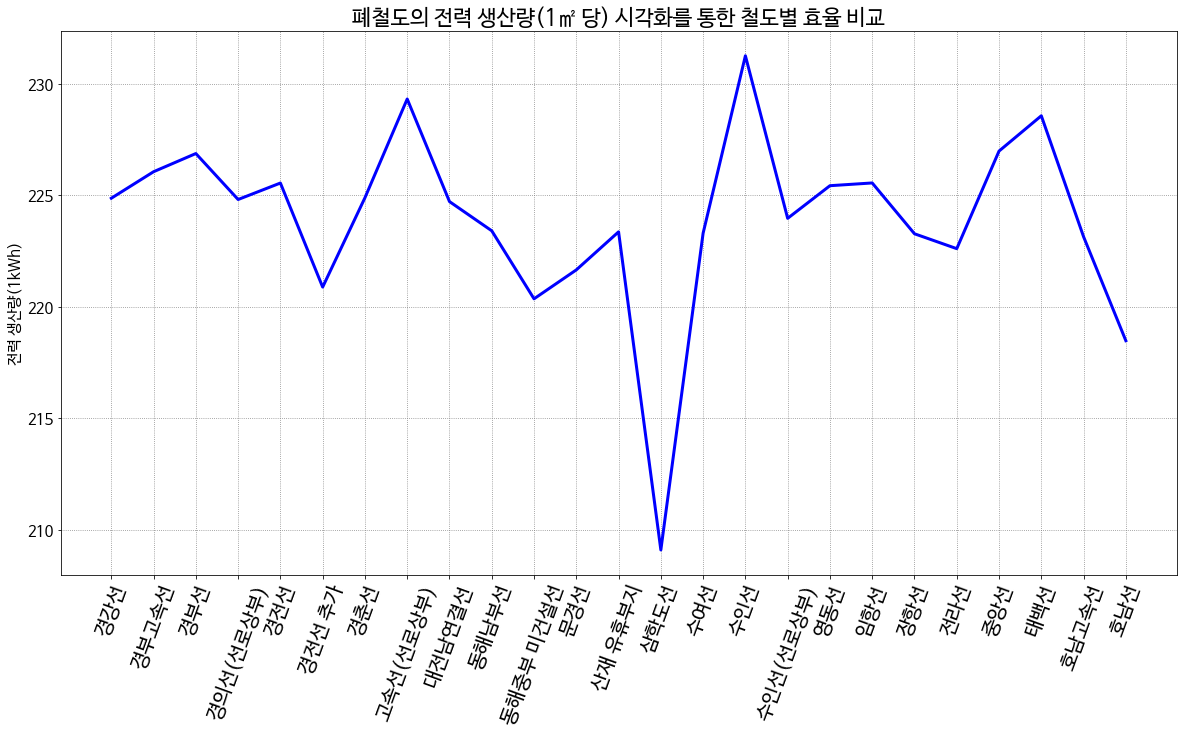

In [182]:
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams["figure.figsize"] = (20, 10)

# 그래프 시각화
plt.rc('font', size=18)        # 기본 폰트 크기
plt.rc('axes', labelsize=15)   # x,y축 label 폰트 크기
# plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=15)  # y축 눈금 폰트 크기
plt.grid(linestyle=':',color='0.5')
plt.title('폐철도의 전력 생산량(1㎡ 당) 시각화를 통한 철도별 효율 비교')
plt.ylabel('전력 생산량(1kWh)')
line=plt.plot(power_x,power_y)
plt.setp(line, color='b', linewidth=3.0)
plt.xticks(rotation=70)
plt.show()

## 태양광 부지로 사용 가능한 면적과 전력 생산량 시각화

In [141]:
availArea=Avail_area_sum[Avail_area_sum>0]
availArea

경부선           320736
경춘선            32012
중앙선           870214
경부고속선           6934
경전선          1840496
동해남부선         220839
동해중부 미건설선    1266197
산재 유휴부지       204791
장항선           933515
삼학도선           11511
전라선           362858
호남선           417872
영동선             4443
태백선           230289
dtype: int64

In [142]:
availArea=availArea.sort_values(ascending=False)
availArea

경전선          1840496
동해중부 미건설선    1266197
장항선           933515
중앙선           870214
호남선           417872
전라선           362858
경부선           320736
태백선           230289
동해남부선         220839
산재 유휴부지       204791
경춘선            32012
삼학도선           11511
경부고속선           6934
영동선             4443
dtype: int64

In [144]:
elec=pd.read_csv('./노선별_전력효율.csv')
elec

,노선명,면적,ac_annual,전력생산량 (1㎡ 당)
0,경강선,12028.0,2.704572e+06,224.856329
1,경부고속선,172574.0,3.900956e+07,226.045410
2,경부선,1440647.0,3.268263e+08,226.860755
3,경의선(선로상부),76254.0,1.714188e+07,224.799687
4,경전선,3417817.0,7.708485e+08,225.538258
5,경전선 추가,434361.0,9.593830e+07,220.872261
6,경춘선,1486837.0,3.343563e+08,224.877566
7,고속선(선로상부),21708.0,4.977794e+06,229.306880
8,대전남연결선,131855.0,2.962868e+07,224.706559
9,동해남부선,374609.0,8.368617e+07,223.396042


In [146]:
elec=elec[elec['노선명'].isin(x)]
elec

,노선명,면적,ac_annual,전력생산량 (1㎡ 당)
1,경부고속선,172574.0,3.900956e+07,226.045410
2,경부선,1440647.0,3.268263e+08,226.860755
4,경전선,3417817.0,7.708485e+08,225.538258
6,경춘선,1486837.0,3.343563e+08,224.877566
9,동해남부선,374609.0,8.368617e+07,223.396042
10,동해중부 미건설선,2465277.0,5.432147e+08,220.346324
12,산재 유휴부지,334608.0,7.473449e+07,223.349384
13,삼학도선,11511.0,2.406763e+06,209.083745
17,영동선,617096.0,1.391049e+08,225.418503
19,장항선,1507657.0,3.366042e+08,223.263092


In [147]:
elec.set_index('노선명',inplace=True)
elec=elec['전력생산량 (1㎡ 당)']
elec

노선명
경부고속선        226.045410
경부선          226.860755
경전선          225.538258
경춘선          224.877566
동해남부선        223.396042
동해중부 미건설선    220.346324
산재 유휴부지      223.349384
삼학도선         209.083745
영동선          225.418503
장항선          223.263092
전라선          222.595185
중앙선          226.970802
태백선          228.554380
호남선          218.467990
Name: 전력생산량 (1㎡ 당), dtype: float64

In [148]:
elec=elec.reindex(index=x)
elec

경전선          225.538258
동해중부 미건설선    220.346324
장항선          223.263092
중앙선          226.970802
호남선          218.467990
전라선          222.595185
경부선          226.860755
태백선          228.554380
동해남부선        223.396042
산재 유휴부지      223.349384
경춘선          224.877566
삼학도선         209.083745
경부고속선        226.045410
영동선          225.418503
Name: 전력생산량 (1㎡ 당), dtype: float64

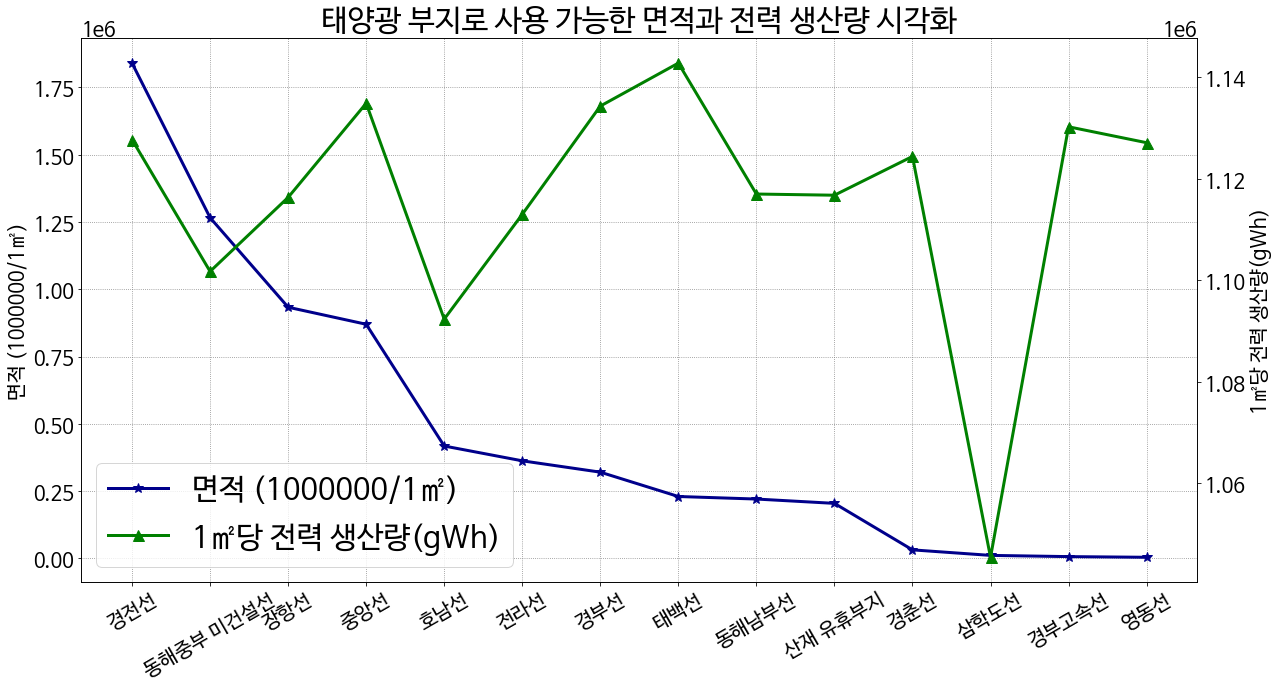

In [149]:
x=availArea.index
y=availArea.values
plt.rc('font', family='NanumBarunGothic') 
plt.rc('font', size=25)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rcParams["figure.figsize"] = (20, 10)

fig, ax1 = plt.subplots()
plt.xticks(rotation=30)
plt.grid(True,linestyle=':',color='0.5')
line1=ax1.plot(x,y,color='darkblue',linewidth=3.0,label='태양광 부지로 사용 가능한 면적(미사용중인 철도의 면적)',marker='*',markersize=11)
ax1.set_ylabel('면적 (1000000/1㎡)')

ax2=ax1.twinx()
line2=ax2.plot(x,elec.values*5000,color='green',linewidth=3.0,label='전력 생산 효율',marker='^',markersize=11)
ax2.set_ylabel('1㎡당 전력 생산량(gWh)')

# 그래프 설정
plt.title('태양광 부지로 사용 가능한 면적과 전력 생산량 시각화')
ax1.legend(line1+line2,['면적 (1000000/1㎡)','1㎡당 전력 생산량(gWh)'],loc='lower left')
plt.show()

## 폐철도 위 폐터널의 면적 시각화

#폐철도에 태양광 설치시 수익 시각화

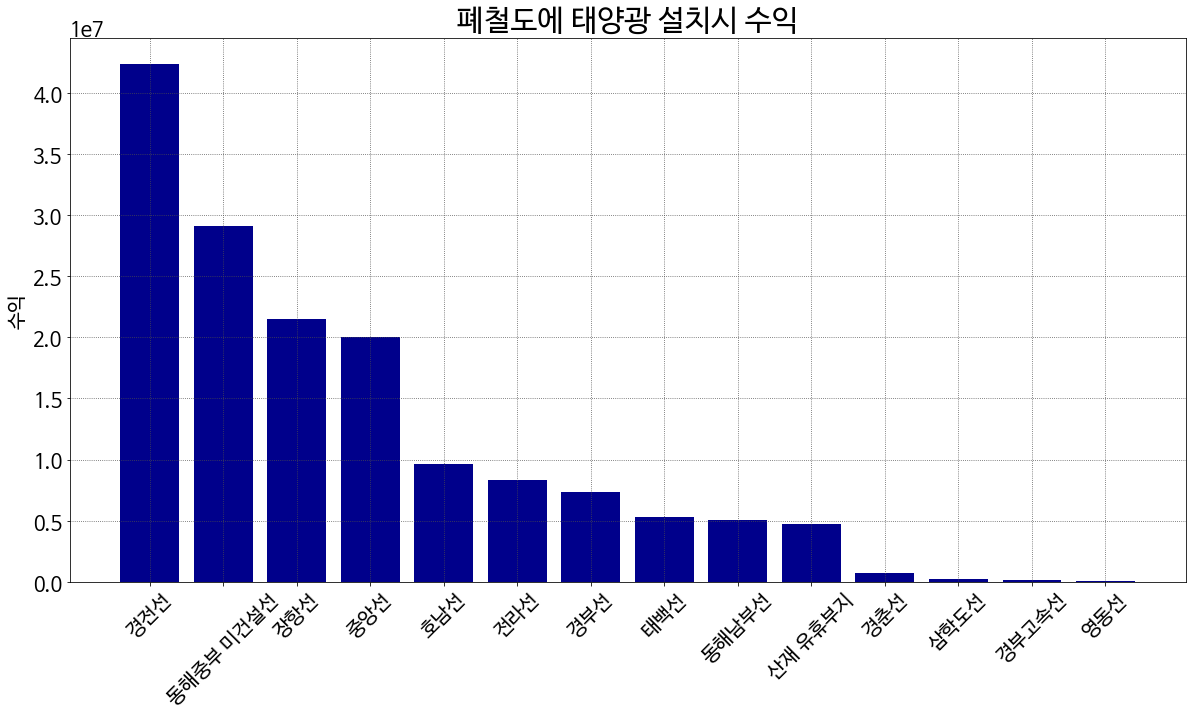

In [183]:
x=availArea.index
y=availArea.values
plt.rc('font', family='NanumBarunGothic') 
plt.rc('font', size=25)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.grid(linestyle=':',color='0.3')
plt.rcParams["figure.figsize"] = (20, 10)
plt.title('폐철도에 태양광 설치시 수익')
plt.ylabel('수익')
line=plt.bar(x,y*23,color='darkblue',linewidth=4.0,label='태양광 부지로 사용 가능한 면적(미사용중인 철도의 면적)')
plt.plot()
plt.setp(line, linewidth=3.0)
plt.xticks(rotation=45)
# plt.legend('태양광 부지로 사용 가능한 면적(미사용중인 철도의 면적)')
plt.show()